# Checking Freshwater River Runoff

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm

In [2]:
db='/g/data/ik11/outputs/mom6-panan/panant.db'
session=cc.database.create_session(db)

# Loading original v1-3 runoff file from JRA RYF

In [10]:
runoff = xr.open_dataset('/g/data/ua8/JRA55-do/RYF/v1-3/RYF.runoff_all.1990_1991.nc').friver
area = np.ones([720,1440])
lon,lat = np.meshgrid(runoff.longitude.values,runoff.latitude.values)
area = area*110e3**2/16*np.cos(np.pi*lat/180)
runoff_JRA=(runoff*area).isel(time=slice(59,90)).mean('time').sum('longitude').cumsum('latitude').sel(latitude=slice(-82,-37)).load()# loads for March

In [ ]:
friver = cc.querying.getvar(expt='panant-v3', variable='friver', session=session)
areacello = cc.querying.getvar(expt='panant-v3', variable='areacello', session=session,n=-1)
runoff_panant = (friver*areacello).mean('time').sum('xh').cumsum('yh')

In [8]:
friver = cc.querying.getvar(expt='panant-01-zstar', variable='friver', session=session)
areacello = cc.querying.getvar(expt='panant-01-zstar', variable='areacello', session=session,n=-1)
runoff_panant_01 = (friver*areacello).isel(time=1).sum('xh').cumsum('yh').load() # loads for March

<xarray.DataArray 'friver' (time: 10, yh: 845, xh: 3600)>
dask.array<concatenate, shape=(10, 845, 3600), dtype=float32, chunksize=(1, 845, 3600), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -81.11 -81.07 -81.02 -80.98 ... -37.3 -37.22 -37.14
  * time     (time) object 1991-03-16 12:00:00 ... 1991-12-16 12:00:00
  * xh       (xh) float64 -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
Attributes:
    units:          kg m-2 s-1
    long_name:      Water Flux into Sea Water From Rivers
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  water_flux_into_sea_water_from_rivers
    time_bnds:      <xarray.DataArray 'time_bnds' (time: 10, nv: 2)>\ndask.ar...
    ncfiles:        ['/g/data/x77/amh157/PanAnt/archive/panant-01-zstar/outpu...

In [26]:
ds = xr.open_dataset('/g/data/x77/amh157/mom6/regrid_runoff/RYF.runoff_all.1990_1991.panan01.nc',decode_times=False)
runoff = ds.friver
area = ds.area
#runoff_new = (runoff*area).isel(time=slice(0,31)).mean('time').sum('i').cumsum('j').load()
lat_panan = ds.lat.values[:,0]

In [31]:
ds = xr.open_dataset('/g/data/x77/amh157/mom6/regrid_runoff/RYF.friver.1990_1991.nc')
friver = ds.friver
area = ds.area
licalvf = xr.open_dataset('/g/data/x77/amh157/mom6/regrid_runoff/RYF.licalvf.1990_1991.nc').licalvf
runoff_OM4 = ((friver+licalvf)*area).isel(time=slice(0,31)).mean('time').sum('i').cumsum('j').load()
lat_OM4 = ds.lat.values[:,0]

In [17]:
ds = xr.open_dataset('/g/data/x77/amh157/PanAnt/archive/panant-01-zstar/output000/19910101.ocean_month.nc')
ds

<xarray.Dataset>
Dimensions:     (xq: 3601, yh: 845, time: 1, nv: 2, xh: 3600, yq: 846)
Coordinates:
  * xq          (xq) float64 -280.0 -279.9 -279.8 -279.7 ... 79.7 79.8 79.9 80.0
  * yh          (yh) float64 -81.11 -81.07 -81.02 -80.98 ... -37.3 -37.22 -37.14
  * time        (time) object 1991-01-16 12:00:00
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yq          (yq) float64 -81.13 -81.09 -81.05 -81.0 ... -37.26 -37.18 -37.1
Data variables:
    umo_2d      (time, yh, xq) float32 ...
    vmo_2d      (time, yq, xh) float32 ...
    tauuo       (time, yh, xq) float32 ...
    tauvo       (time, yq, xh) float32 ...
    hfds        (time, yh, xh) float32 ...
    wfo         (time, yh, xh) float32 ...
    average_T1  (time) datetime64[ns] ...
    average_T2  (time) datetime64[ns] ...
    average_DT  (time) timedelta64[ns] ...
    time_bnds   (time, nv) timedelta64[ns] ...
Attributes:
    NumFilesInSet:     1
    title:             panan
    associated_files:  areacello: 19910101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

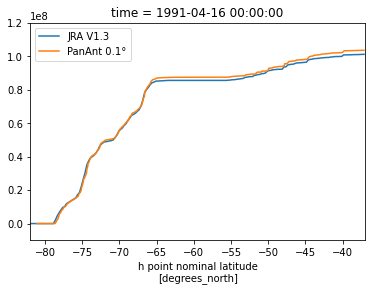

In [11]:
## Plot January runoff, cumulatively integrating from South.
runoff_JRA.plot(label='JRA V1.3')
runoff_panant_01.plot(label='PanAnt 0.1°')
#plt.plot(lat_panan,runoff_new,label='Regrid Panant 0.1°')
#plt.plot(lat_OM4,runoff_OM4,label='Regrid OM4')
plt.xlim([-82,-37])
plt.ylim([-1e7,1.2e8])
plt.legend()

## Checking cropped runoff against panan-01 mask

In [3]:
ds = xr.open_dataset('/g/data/ik11/inputs/mom6/regrid_runoff/RYF.runoff_all.1990_1991.panan01_cropped.nc')

In [5]:
friver = ds.friver
area = ds.area
runoff = friver*area

In [8]:
runoff_mean = runoff.sum('time').load()

In [7]:
mask = xr.open_dataset('/g/data/x77/ahg157/inputs/mom6/panan-01/ocean_mask.nc').mask

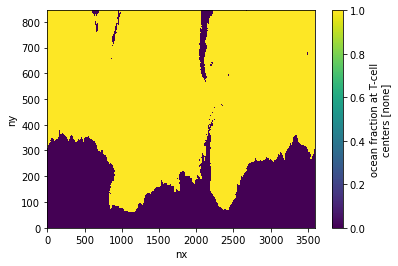

In [12]:
mask.plot()

In [14]:
runoff_mean.sum(dim={'j','i'})

<xarray.DataArray ()>
array(3.99200053e+10)

In [15]:
(runoff_mean*mask.values).sum(dim={'j','i'})

<xarray.DataArray ()>
array(3.99200053e+10)

In [16]:
(runoff_mean*(1-mask.values)).sum(dim={'j','i'})

<xarray.DataArray ()>
array(0.)